**Как было описано по заданию, в датасете некоторые кратинки которые имеют неправильный target. Из за этого мы саморучно датсет отсортировали на папки Fire(есть огонь) и Firenetu(нету огня). И далее создали модель при помощи tensorflow на Conv Nets**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import cv2
import imghdr
import os
import tensorflow as tf

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = '/content/drive/MyDrive/train_images (1)'
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [4]:
data_dir

'/content/drive/MyDrive/train_images (1)'

In [5]:
for image_class in os.listdir(data_dir): 
  print(image_class)

Fire
Firenetu


In [6]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [7]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/train_images (1)', labels = 'inferred', class_names = ['Firenetu','Fire'])

Found 2619 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()

In [9]:
batch = data_iterator.next()

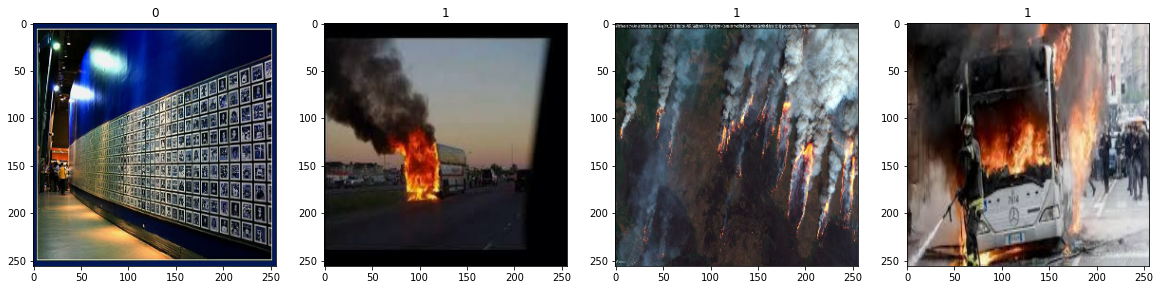

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [11]:
data = data.map(lambda x,y: (x/255, y))

In [12]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [18]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [51]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
57/57 [==============================] - 148s 3s/step - loss: 0.0205 - accuracy: 0.9945 - val_loss: 0.3701 - val_accuracy: 0.9238
Epoch 2/5
57/57 [==============================] - 149s 3s/step - loss: 0.0209 - accuracy: 0.9945 - val_loss: 0.2833 - val_accuracy: 0.9355
Epoch 3/5
57/57 [==============================] - 130s 2s/step - loss: 0.0168 - accuracy: 0.9962 - val_loss: 0.2871 - val_accuracy: 0.9355
Epoch 4/5
57/57 [==============================] - 150s 3s/step - loss: 0.0215 - accuracy: 0.9934 - val_loss: 0.2825 - val_accuracy: 0.9277
Epoch 5/5
57/57 [==============================] - 149s 3s/step - loss: 0.0076 - accuracy: 0.9984 - val_loss: 0.3389 - val_accuracy: 0.9375


In [136]:
from pathlib import Path
import os.path
dataset = "/content/drive/MyDrive/test_imgs"
image_dir = Path(dataset)
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)

In [137]:
image_df = pd.DataFrame(filepaths)

In [138]:
def preprocessing_image(filepath):
  img = cv2.imread(filepath) #read
  img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR) #convert
  img = cv2.resize(img,(256,256))  # resize
  img = img / 255 #scale
  return img 

In [139]:
image_df['Labels'] = 1

In [140]:
def create_format_dataset(dataframe):
  X = []
  y = []
  for f,t in dataframe.values:
    X.append(preprocessing_image(f))
    y.append(t)
  
  return np.array(X),np.array(y)

In [141]:
X, y = create_format_dataset(image_df)

In [142]:
image_df = image_df['Filepath'].str.split("/",n=5, expand=True)[5]
image_df = image_df.to_frame()
image_df.rename(columns ={5:'filename'}, inplace=True)

In [143]:
predictions = np.round(model.predict(X))

13/13 [==============================] - 6s 455ms/step


In [144]:
image_df

,filename
0,604.jpg
1,189.jpg
2,823.jpg
3,63.jpg
4,610.jpg
...,...
395,91.jpg
396,153.jpg
397,621.jpg
398,46.jpg


In [145]:
predictions = predictions.reshape(-1)
image_df['class_id'] = predictions

In [147]:
image_df['class_id'] = image_df['class_id'].astype('int')
image_df['class_id'] = image_df['class_id'].astype('str')

In [148]:
df = pd.DataFrame()
df['test_labels'] = image_df['filename'] + ", " + image_df['class_id']
df['test_labels'] = df['test_labels'].apply(lambda x : x.replace('jpg', 'json'))

In [149]:
df

,test_labels
0,"604.json, 1"
1,"189.json, 0"
2,"823.json, 0"
3,"63.json, 0"
4,"610.json, 1"
...,...
395,"91.json, 0"
396,"153.json, 1"
397,"621.json, 0"
398,"46.json, 1"


In [135]:
df.to_csv('test_results.csv')